<!--
clang-format off
-->

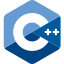
<br>

<div style="text-align:center; font-size:200%;">
 <b>SOLID: Dependency-Inversions-Prinzip</b>
</div>
<br/>
<div style="text-align:center; font-size:120%;">Dr. Matthias Hölzl</div>
<br/>
<div style="text-align:center;">Coding-Akademie München</div>
<br/>
<!-- 12 SOLID Dependency-Inversions-Prinzip.ipynb -->
<!-- slides/module_500_solid_grasp/topic_400_solid_dip.cpp -->


# Abhängigkeiten

- Wir müssen zwei Arten von Abhängigkeiten unterscheiden:
  - Daten- und Kontrollfluss
  - Quellcode-Abhängigkeiten
- Daten- und Kontrollfluss-Abhängigkeiten sind inhärent in der Logik
- Quellcode-Abhängigkeiten können wir durch die Architektur kontrollieren


## Beispiel

- Modul `MyModule.cpp` schreibt Daten in eine Datenbank
- Datenfluss: von `MyModule.cpp` zur Datenbank
- Quellcode-Abhängigkeit: `MyModule.cpp` hängt von der Datenbank (`Database.h`) ab


Modul `MyModule.cpp`:

In [ ]:
#include <string>
#include <vector>
#include <xcpp/xdisplay.hpp>

#include "Database.h"

In [ ]:
class MyDomainClassV1
{
public:
    void PerformWork(std::string data)
    {
        data = "Processed: " + data;
        db.Execute("INSERT INTO my_table VALUES (?)", data);
    }

    std::vector<std::string> RetrieveResult()
    {
        return db.Execute("SELECT * FROM my_table");
    }

private:
    Database db;
};

In [ ]:
MyDomainClassV1 myDomainObjectV1{};

In [ ]:
myDomainObjectV1.PerformWork("Hello World");

In [ ]:
xcpp::display(myDomainObjectV1.RetrieveResult());


Die Quellcode-Abhängigkeit geht in die gleiche Richtung wie der Datenfluss:

`MyModule.cpp` ⟹ `Database.h`

<img src="img/db-example-01.svg"
     style="display:block;margin:auto;width:75%"/>


Wir würden derartige Abhängigkeiten im Kern unsere Anwendung gerne vermeiden

- Einfacher zu testen
- Einfacher zu erweitern
- Einfacher externe Abhängigkeiten zu ersetzen
- Einfacher den Code zu verstehen
- ...


<img src="img/db-example-02.svg"
     style="display:block;margin:auto;width:75%"/>


- Modul `MyModule.cpp`:
  - Keine Abhängigkeit mehr zu `Database.h`
  - Adapter Pattern

In [ ]:
class AbstractDatabaseAdapter
{
public:
    AbstractDatabaseAdapter() = default;
    virtual ~AbstractDatabaseAdapter() = default;

    virtual void SaveObject(std::string data) = 0;
    virtual std::vector<std::string> RetrieveData() = 0;
};

In [ ]:
class MyDomainClassV2
{
public:
    MyDomainClassV2(std::unique_ptr<AbstractDatabaseAdapter> db) : db_{std::move(db)} {}

    void PerformWork(std::string data)
    {
        data = "Processed: " + data;
        db_->SaveObject(data);
    }

    std::vector<std::string> RetrieveResult() { return db_->RetrieveData(); }

private:
    std::unique_ptr<AbstractDatabaseAdapter> db_;
};


- Modul `ConcreteDatabaseAdapter.cpp/.h`:
  - Implementiert `AbstractDatabaseAdapter` für `Database.h`
  - Hängt von `Database.h` ab

In [ ]:
#include "Database.h"

In [ ]:
class ConcreteDatabaseAdapter : public AbstractDatabaseAdapter
{
public:
    void SaveObject(std::string data) override
    {
        db_.Execute("INSERT INTO my_table VALUES (?)", data);
    }

    std::vector<std::string> RetrieveData() override
    {
        return db_.Execute("SELECT * FROM my_table");
    }

private:
    Database db_;
};


- Modul `main.cpp`:

In [ ]:
// #include "ConcreteDatabaseAdapter.h"
// #include "MyDomainClassV2.h"

In [ ]:
auto dbAdapter{std::make_unique<ConcreteDatabaseAdapter>()};
MyDomainClassV2 myDomainObjectV2{std::move(dbAdapter)};

In [ ]:
myDomainObjectV2.PerformWork("Hello World");

In [ ]:
xcpp::display(myDomainObjectV2.RetrieveResult());


# SOLID: Dependency Inversion Prinzip

- Die Kernfunktionalität eines Systems hängt nicht von seiner Umgebung ab
  - **Konkrete Artefakte hängen von Abstraktionen ab** (nicht umgekehrt)
  - **Instabile Artefakte hängen von stabilen Artefakten ab** (nicht umgekehrt)
  - **Äußere Schichten** der Architektur **hängen von inneren Schichten ab**
    (nicht umgekehrt)
  - Klassen/Module hängen von Abstraktionen (z. B. Schnittstellen) ab,
    nicht von anderen Klassen/Modulen
- Abhängigkeitsinversion (Dependency Inversion) erreicht dies durch die Einführung
  von Schnittstellen, die "die Abhängigkeiten umkehren"


### Vorher
<img src="img/dependency-01.svg"
     style="display:block;margin:auto;width:75%"/>

### Nachher
<img src="img/dependency-02.svg"
     style="display:block;margin:auto;width:75%"/>


<img src="img/dip-01.svg"
     style="display:block;margin:auto;width:95%"/>


<img src="img/dip-02.svg"
     style="display:block;margin:auto;width:95%"/>


<img src="img/dip-03.svg"
     style="display:block;margin:auto;width:95%"/>


## Workshop: Wetterbericht

Wir haben ein Programm geschrieben, das einen Wetterbericht von einem Server
abruft. Leider ist dabei die Abhängigkeit zum Server vom Typ
`LegacyWeatherServer` hart kodiert. Aufgrund der Popularität des Programms
müssen wir jedoch mit einem neuen Typ von Server `NewWeatherServer`
kompatibel werden. Dazu refaktorisieren wir den Code nach dem
Dependency-Inversion-Prinzip und Implementieren dann einen zusätzlichen
Adapter für `NewWeatherServer`.

- Führen Sie eine Abstraktion ein, um die Abhängigkeit umzukehren
- Schreiben Sie eine konkrete Implementierung der Abstraktion für
  `LegacyWeatherServer`
- Testen Sie die Implementierung
- Implementieren Sie einen Adapter für `NewWeatherServer`
- Testen Sie den Adapter

In [ ]:
#include <iostream>
#include <random>
#include <string>
#include <tuple>
#include <vector>

In [ ]:
class WeatherReport
{
public:
    WeatherReport(double temperature, double humidity)
        : temperature_{temperature}, humidity_{humidity}
    {}

    double GetTemperature() const { return temperature_; }
    double GetHumidity() const { return humidity_; }

private:
    double temperature_;
    double humidity_;
};

In [ ]:
class LegacyWeatherServer
{
public:
    WeatherReport GetWeatherReport()
    {
        static std::random_device rd;
        static std::mt19937 gen{rd()};
        static std::uniform_real_distribution<> dis{0.0, 1.0};
        return WeatherReport{20.0 + 10.0 * dis(gen), 0.5 + 0.5 * dis(gen)};
    }
};

In [ ]:
class NewWeatherServer
{
public:
    std::tuple<double, double> FetchWeatherData()
    {
        static std::random_device rd;
        static std::mt19937 gen{rd()};
        static std::uniform_real_distribution<> dis{0.0, 1.0};
        return {10.0 + 20.0 * dis(gen), 0.7 + 0.4 * dis(gen)};
    }
};

In [ ]:
class WeatherReporter
{
public:
    WeatherReporter(std::shared_ptr<LegacyWeatherServer> server)
        : server{std::move(server)}
    {}

    std::string Report()
    {
        WeatherReport report{server->GetWeatherReport()};
        if (report.GetTemperature() > 25.0f)
        {
            return "It's hot";
        }
        else
        {
            return "It's not hot";
        }
    }

private:
    std::shared_ptr<LegacyWeatherServer> server;
};

In [ ]:
std::shared_ptr<LegacyWeatherServer> server{std::make_shared<LegacyWeatherServer>()};
WeatherReporter reporter{server};

In [ ]:
xcpp::display(reporter.Report());